# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, or email.


In [132]:
!nvidia-smi # Check GPU

import os
from google.colab import drive
drive.mount('/content/drive') # Mount to google drive
os.chdir('/content/drive/MyDrive/ML2023Spring/hw1')
os.listdir() # Check Dir

Mon Mar 13 09:04:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |    805MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

['ML2021Spring_HW1 2.ipynb',
 'data',
 '.ipynb_checkpoints',
 'models',
 'results',
 'sample',
 'ML_411185050_HW1.ipynb']

# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ntpucsie-ml2022spring-hw1-v2), and upload data manually to the workspace.

如果需要邀請，邀請連結，這是[邀請連結](https://www.kaggle.com/t/7d7a965ceab54a46b9ec76973c25149a)

In [133]:
tr_path = 'data/covid.train_v2.csv'  # path to training data
tt_path = 'data/covid.test_v2.csv'   # path to testing data

!gdown '1Wweg6vyFs2GbLzbi4CLA64cWb1gQafPA' --output data/covid.train_v2.csv
!gdown '1VtQ8E3cy6gatnYPkJZ7f4BkLA7BmQhyd' --output data/covid.test_v2.csv

Downloading...
From: https://drive.google.com/uc?id=1Wweg6vyFs2GbLzbi4CLA64cWb1gQafPA
To: /content/drive/MyDrive/ML2023Spring/hw1/data/covid.train_v2.csv
100% 1.58M/1.58M [00:00<00:00, 138MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VtQ8E3cy6gatnYPkJZ7f4BkLA7BmQhyd
To: /content/drive/MyDrive/ML2023Spring/hw1/data/covid.test_v2.csv
100% 408k/408k [00:00<00:00, 66.8MB/s]


# **Import Some Packages**

In [134]:
# Custom Packages
import time # For file name

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 53489  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Some Utilities**

You do not need to modify this part.

In [135]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 4.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

# Feature Selection

In [136]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

def FeatureSelection(num = 20):
  data = pd.read_csv(tr_path)
  x = data[data.columns[1:94]]
  y = data[data.columns[-1]]
  best = SelectKBest(score_func=f_regression, k='all')
  fit = best.fit(x, y)
  scores = pd.DataFrame(fit.scores_)
  columns = pd.DataFrame(x.columns)
  table = pd.concat([scores, columns], axis=1)
  table.columns = ['Score', 'Feature']
  print(table.nlargest(num, 'Score'))
  selectedFeatures = list(scores.nlargest(20, 0).index)
  return selectedFeatures

# num = 20: (epoch =  471, loss = 0.8643)
# num = 15: (epoch =  471, loss = 0.8643)
selectedFeatures = FeatureSelection(14) # Fixed features
print('Selected Features: {}'.format(selectedFeatures))

            Score            Feature
75  125451.082667  tested_positive.1
57   60306.597235    tested_positive
42    7434.712354       hh_cmnty_cli
60    7350.677778     hh_cmnty_cli.1
78    7241.555065     hh_cmnty_cli.2
43    6761.973441     nohh_cmnty_cli
61    6683.693337   nohh_cmnty_cli.1
79    6569.078833   nohh_cmnty_cli.2
40    5284.981344                cli
58    5279.286705              cli.1
76    5157.855546              cli.2
41    4992.650580                ili
59    4945.501701              ili.1
77    4798.580200              ili.2
Selected Features: [75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77, 92, 74, 56, 87, 69, 83]


## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [137]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            feats = list(range(93))
        else:
            #feats = list(range(1, 41)) + [57, 75]
            feats = selectedFeatures # Use sklearn's result to help choose better features

        if mode == 'test':
            # Testing data
            # data: 560 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2140 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]

            self.mean = torch.FloatTensor(data).mean(dim=0, keepdim=True)
            self.std = torch.FloatTensor(data).std(dim=0, keepdim=True)
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 5 != 0]
                #indices = [i for i in range(len(data))]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 5 == 0]
                #indices = [i for i in range(len(data))]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

    def normalization(self, mean=None, std=None):
        if self.mode == 'train' or self.mode =='dev':
            mean = self.mean
            std = self.std 
            self.data =  (self.data-mean) / std
        else:
            self.data =  (self.data-mean) / std
            
        return mean, std

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [138]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False, mean=None, std=None):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    mean, std = dataset.normalization(mean, std)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader, mean, std

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [139]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential( # Smaller better?
            nn.Linear(input_dim, 20),
            nn.Dropout(p=0.2), # 0.1 with 0.8192 public 1.06312 0.2 with 0.8354
            nn.LeakyReLU(),
            nn.Linear(20, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target, l1_lambda):
        # L1
        l1_regulation = torch.tensor(0.).to(device)
        for parameter in model.parameters():
          l1_regulation += torch.sum(torch.abs(parameter))
        return self.criterion(pred, target) + (l1_lambda * l1_regulation)

# **Train/Dev/Test**

## **Training**

In [140]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y, config['l1_lambda'])  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## **Validation**

In [141]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y, config['l1_lambda'])  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [142]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [143]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                   # TODO: Using 40 states & 2 tested_positive features
time_stamp = str(int(time.time()))
# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 10000,                # maximum number of epochs
    'batch_size': 200,               # mini-batch size for dataloader
    'optimizer': 'RAdam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.003,                 # learning rate of SGD
        #'weight_decay': 1e-5          # L2
        #'momentum': 0.9              # momentum for SGD
    },
    'l1_lambda': 1e-5,                # L1
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model_{}.pth'.format(time_stamp)  # your model will be saved here
}

# **Load data and model**

In [144]:
tr_set, mean, std = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set, _, _ = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only, mean=mean, std=std)
tt_set, _, _ = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only, mean=mean, std=std)

Finished reading the train set of COVID19 Dataset (1712 samples found, each dim = 20)
Finished reading the dev set of COVID19 Dataset (428 samples found, each dim = 20)
Finished reading the test set of COVID19 Dataset (560 samples found, each dim = 20)


In [145]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

# **Start Training!**

In [146]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 235.8565)
Saving model (epoch =    2, loss = 234.2047)
Saving model (epoch =    3, loss = 231.7642)
Saving model (epoch =    4, loss = 228.6868)
Saving model (epoch =    5, loss = 224.9763)
Saving model (epoch =    6, loss = 220.6514)
Saving model (epoch =    7, loss = 215.6914)
Saving model (epoch =    8, loss = 210.1659)
Saving model (epoch =    9, loss = 204.0141)
Saving model (epoch =   10, loss = 197.3191)
Saving model (epoch =   11, loss = 190.0470)
Saving model (epoch =   12, loss = 182.3263)
Saving model (epoch =   13, loss = 174.2173)
Saving model (epoch =   14, loss = 165.7544)
Saving model (epoch =   15, loss = 157.0649)
Saving model (epoch =   16, loss = 148.2729)
Saving model (epoch =   17, loss = 139.4373)
Saving model (epoch =   18, loss = 130.8675)
Saving model (epoch =   19, loss = 122.5559)
Saving model (epoch =   20, loss = 114.8198)
Saving model (epoch =   21, loss = 107.6488)
Saving model (epoch =   22, loss = 101.1361)
Saving mod

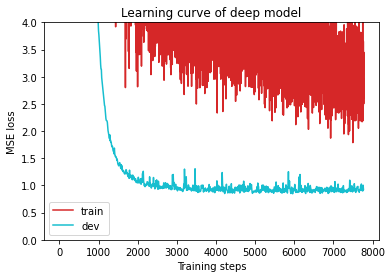

In [147]:
plot_learning_curve(model_loss_record, title='deep model')

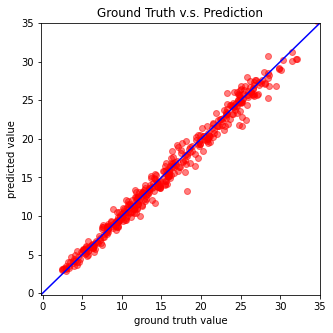

In [148]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [149]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])
preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'results/pred_{}.csv'.format(time_stamp))         # save prediction file to pred.csv


Saving results to results/pred_1678698297.csv


# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)
* 注意註解，或許可以發現隱藏在code裡的bug。

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
